In [1]:
# This .py file record the sensed force from the contact surface by a simple test. 
# A box is falling on a floor, then an external force is applied on the center of box, 
# but the max force do not exceed the max friction.



import matplotlib.pyplot as plt
import numpy as np
import pydrake
from pydrake.all import (AddMultibodyPlantSceneGraph, Box,
                         ConstantVectorSource, ContactVisualizer,
                         ContactVisualizerParams, DiagramBuilder,
                         DiscreteContactSolver, FindResourceOrThrow,
                         FixedOffsetFrame, InverseDynamicsController,
                         JointSliders, LeafSystem, LogVectorOutput,
                         MathematicalProgram, MeshcatVisualizer,
                         MeshcatVisualizerParams, MultibodyPlant,ZeroOrderHold,
                         MultibodyPositionToGeometryPose, Multiplexer,AbstractValue,ContactResults,
                         OsqpSolver, Parser, PiecewisePolynomial, PlanarJoint,
                         PrismaticJoint, RevoluteJoint, RigidTransform,BasicVector,
                         RotationMatrix, SceneGraph, Simulator, SpatialInertia,
                         Sphere, StartMeshcat, TrajectorySource, UnitInertia)

from manipulation import running_as_notebook
from manipulation.meshcat_utils import MeshcatSliders
from manipulation.scenarios import AddShape, SetColor, SetTransparency
from manipulation.utils import FindResource
# Start the visualizer.
import warnings
warnings.filterwarnings("ignore")

meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [2]:
def Addfloor(plant):
    parser = Parser(plant)
    floor_path= "./verification_floor.sdf"
    floor=parser.AddModelFromFile(floor_path)
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("paddle2", floor),
                     RigidTransform(RotationMatrix.MakeXRotation(np.pi*0/180),
                                    [0,0,0]))
    return floor

In [3]:
def AddBox(plant):
    parser = Parser(plant)
    box_path = "./verification_box.sdf"
    my_box = parser.AddModelFromFile(box_path)
                                           
    false_body1 = plant.AddRigidBody(
        "false_body1", my_box, SpatialInertia(0, [0, 0, 0],
                                              UnitInertia(0, 0, 0)))
    false_body2 = plant.AddRigidBody(
        "false_body2", my_box, SpatialInertia(0, [0, 0, 0],
                                              UnitInertia(0, 0, 0)))
    joint_x = plant.AddJoint(
        PrismaticJoint("joint_x", plant.world_frame(),
                       plant.GetFrameByName("false_body1"), [1, 0, 0], -5, 5))
    plant.AddJointActuator("joint_x", joint_x)
    joint_z = plant.AddJoint(
        PrismaticJoint("joint_z", plant.GetFrameByName("false_body1"),
                       plant.GetFrameByName("false_body2"), [0, 0, 1], -5, 5))
    plant.AddJointActuator("joint_z", joint_z)
    
    joint_theta = plant.AddJoint(
        RevoluteJoint("joint_theta", plant.GetFrameByName("false_body2"),
                       plant.GetFrameByName("paddleh"), [0, 1, 0], 0.5))
    plant.AddJointActuator("joint_theta", joint_theta)
    return my_box

In [4]:
class Box_on_floor(LeafSystem):

    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self.contF_box=np.array([0,0,0,0,0,0])
        self.all_command=np.array([0,0,0])
        self.count=0
        self.DeclareAbstractInputPort("contact_results",
                                      AbstractValue.Make(ContactResults()))
        self.DeclareVectorOutputPort("actuation", 3, self.CalcOutput)

    def CalcOutput(self, context, output):
        self.count=self.count+1
        g = self._plant.gravity_field().gravity_vector()[[0,2]]
        results = self.get_input_port(0).Eval(context)
        if results.num_hydroelastic_contacts() == 0:
            self.contF_box = np.vstack((self.contF_box, [0,0,0,0,0,0]))
        for i in range(results.num_hydroelastic_contacts()):
            info = results.hydroelastic_contact_info(i)
            this_F=info.F_Ac_W().get_coeffs()
            self.contF_box = np.vstack((self.contF_box, this_F))    
        k=1/1000
        if self.count < 1500:
            F=[0,0,0]  
        elif self.count < 2500:
            F=[k*(self.count-1500), 0, 0]
        else:
            F=[k*(2500-1500), 0, 0]
        output.SetFromVector(F) 
        self.all_command = np.vstack((self.all_command, F))

In [5]:
# before plant finish 
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
box = Addfloor(plant)
my_box = AddBox(plant)
plant.GetJointByName("joint_x").set_default_translation(0)
plant.GetJointByName("joint_z").set_default_translation(0.2)
plant.Finalize()

MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
ContactVisualizer.AddToBuilder(
    builder, plant, meshcat,
    ContactVisualizerParams(radius=0.005))

# add system
controller = builder.AddSystem(Box_on_floor(plant))
zoh = builder.AddSystem(ZeroOrderHold(0.002,AbstractValue.Make(ContactResults())))
builder.Connect(plant.get_contact_results_output_port(), zoh.get_input_port(0))
builder.Connect(zoh.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), plant.get_actuation_input_port())
logger = LogVectorOutput(plant.get_state_output_port(my_box), builder)


# start diagarm
diagram = builder.Build()
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
simulator.set_target_realtime_rate(0.5) # it defines the time step
simulator.AdvanceTo(6); # total time

(6, 6337)
(6002, 6)
(6002, 3)


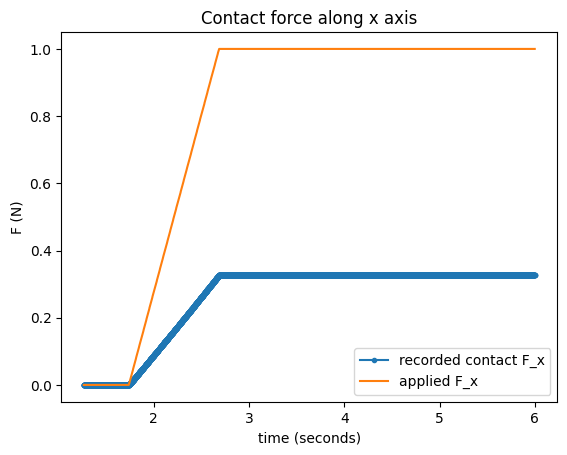

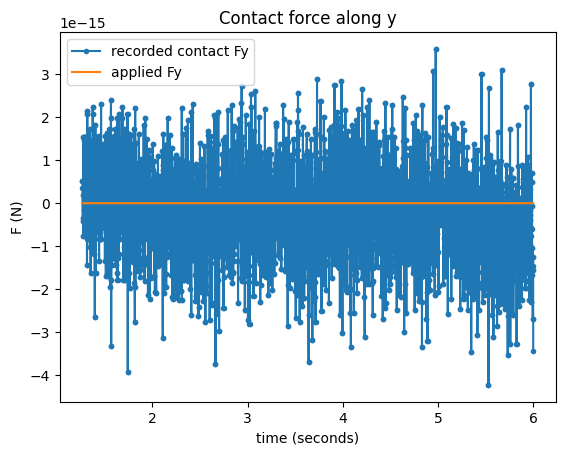

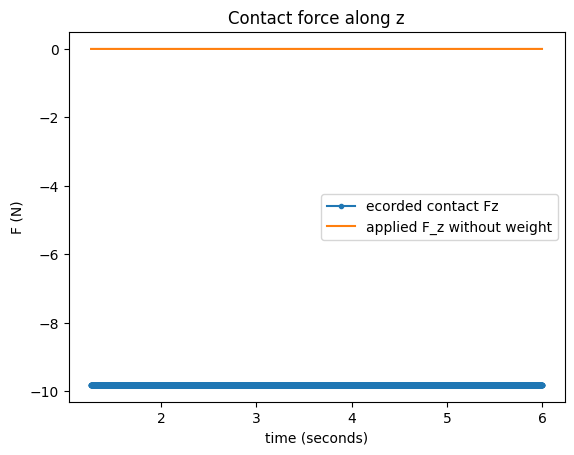

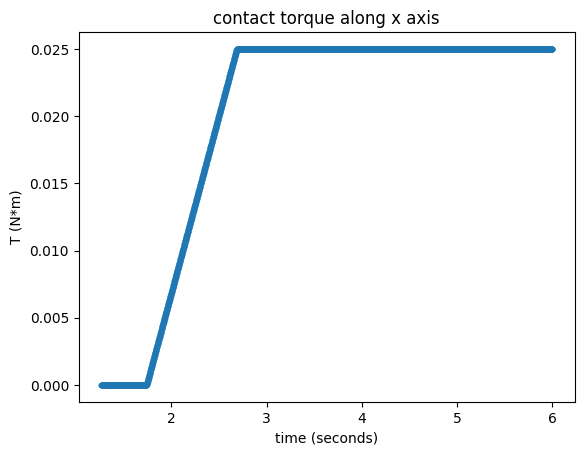

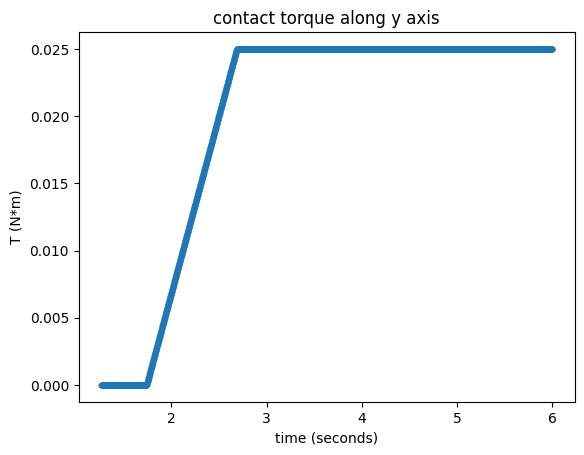

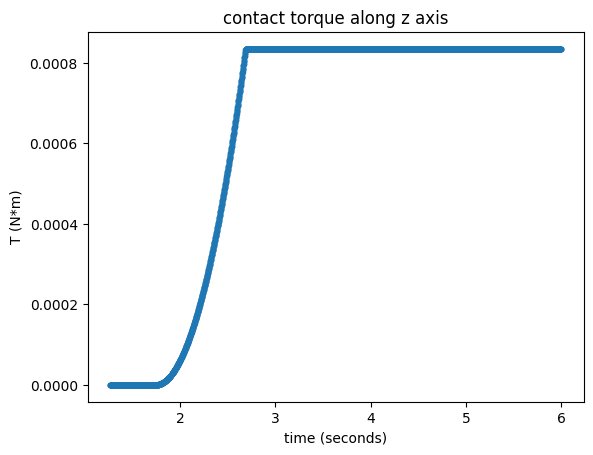

In [9]:
# plot the results, plot contact twist.
    
contF_box=controller.contF_box
all_command=controller.all_command

log = logger.FindMutableLog(context)
t = log.sample_times()
x = log.data()
print(x.shape)
print(contF_box.shape)
print(all_command.shape)

delta=x.shape[1]-contF_box.shape[0]

plus=1000

plt.figure()    
plt.plot(t[delta+plus:-1], contF_box[plus:-1,3],'.-', label="recorded contact F_x")
plt.plot(t[delta+plus:-1], all_command[plus:-1,0] ,label="applied F_x")
plt.legend()
plt.xlabel('time (seconds)')
plt.ylabel('F (N)')
plt.title('Contact force along x axis');

plt.figure()    
plt.plot(t[delta+plus:-1], contF_box[plus:-1,4],'.-', label="recorded contact Fy")
plt.plot(t[delta+plus:-1], all_command[plus:-1,1] ,label="applied Fy")
plt.legend()
plt.xlabel('time (seconds)')
plt.ylabel('F (N)')
plt.title('Contact force along y');

plt.figure()    
plt.plot(t[delta+plus:-1], contF_box[plus:-1,5],'.-', label="ecorded contact Fz")
plt.plot(t[delta+plus:-1], all_command[plus:-1,2] ,label="applied F_z without weight")
plt.legend()
plt.xlabel('time (seconds)')
plt.ylabel('F (N)')
plt.title('Contact force along z');

plt.figure()    
plt.plot(t[delta+plus:-1], contF_box[plus:-1,0],'.-')
plt.xlabel('time (seconds)')
plt.ylabel('T (N*m)')
plt.title('contact torque along x axis');

plt.figure()    
plt.plot(t[delta+plus:-1], contF_box[plus:-1,1],'.-')
plt.xlabel('time (seconds)')
plt.ylabel('T (N*m)')
plt.title('contact torque along y axis');


plt.figure()    
plt.plot(t[delta+plus:-1], contF_box[plus:-1,2],'.-')
plt.xlabel('time (seconds)')
plt.ylabel('T (N*m)')
plt.title('contact torque along z axis');